# <font color=dodgerblue> Add run specifications and prune post-reward data points

## <font color=firebrick> Imports
***

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from file_lists import get_file_list

##  <font color=firebrick> Inputs
    
***

In [2]:
files_path="E:\POSITION DATA/GERONIMO_CTRL5"

##  <font color=firebrick> Functions
***

In [3]:
def find_session_match_in_roi_df(roi_df, session):
    
    '''
    Returns ROI limits from roi_df according to the given session.
    '''
    mask = roi_df['session'].str.contains(session[0:15], regex=False)    
    roi_df = roi_df[mask]

    return roi_df


def find_session_roi_limits_to_plot(b, session): 
    
    '''
    Returns an x and y list of coordinate to draw the ROI on top of the position data.S
    '''
    b = find_session_match_in_roi_df(b, session)

    x = [b['xlim1'].iloc[0], b['xlim1'].iloc[0], b['xlim2'].iloc[0], b['xlim2'].iloc[0], b['xlim1'].iloc[0]]
    y = [b['ylim1'].iloc[0], b['ylim2'].iloc[0], b['ylim2'].iloc[0], b['ylim1'].iloc[0], b['ylim1'].iloc[0]]
        
    return x,y 


def prune_runs(group, rw1_rois, rw2_rois):
    
    '''
    Returns the run data pruned by removing the position data after the rat is detected past the 4 cm until the RW port
    '''  
    # Get RW1 andS RW2 limits according to session
    session = group['session'].iloc[0]
    run_nr = group['run_nr'].iloc[0]
    
  
    if group['stim_condition'].iloc[0] == 2 or group['stim_condition'].iloc[0] == 4:
        
        group.loc[:,:] = np.nan
    
    else:
  
        rw1_session = find_session_match_in_roi_df(rw1_rois, session)
        rw2_session = find_session_match_in_roi_df(rw2_rois, session)
   
        # Create a mask to keep only data inside these ROIS
        rw1_mask = ((group['x'] <= rw1_session['xlim2'].iloc[0]) & 
                   (group['y'].between(rw1_session['ylim1'].iloc[0], rw1_session['ylim2'].iloc[0])))                                                              
        rw2_mask = ((group['x'] <= rw2_session['xlim2'].iloc[0]) & 
                   (group['y'].between(rw2_session['ylim1'].iloc[0], rw2_session['ylim2'].iloc[0])))

        # Apply the mask to the run and collect the first timestamp (1st detected point in either ROIs)
        group_masked = group[((rw2_mask) | (rw1_mask))]

        # Drop data in the run past timestamp
        try:
            timestamp = group_masked['timestamp'].iloc[0]
            group = group[group['timestamp'] <= timestamp]
        except:
            print('removed group: %s, %s'%(session, run_nr))
            group.loc[:,:] = np.nan

    return group

## <font color=mediumseagreen> Open the timestamped position DataFrame
***

In [4]:
# Find rat code in files_path.
match = re.search(r"_(\w+\d+)", files_path)
rat = match.group(1)

# Open raw data from step2 
path = os.path.join(files_path, "Timestamped_position", "%s_timestamped_position_df_raw.csv"%rat)
df1 = pd.read_csv(path, header=0, index_col=0)

## <font color=mediumseagreen> Add the run specifications to each run
***

In [6]:
# Add three new columns to df
df2 = pd.DataFrame(columns=['run_type', 'stim_condition', 'outcome'])
df = pd.concat([df1, df2], axis=1)

# Collect list of file names within files_path containing the given string pattern
run_specs_path = os.path.join(files_path, "Run_specs")
run_specs_files = pd.Series(get_file_list(run_specs_path, "*.csv"))

# Collect list of session codes from data
sessions = df['session'].unique().tolist()

for session in sessions:
    print(session)
    contain_match_mask = run_specs_files.str.contains(session) 
    run_specs_file = (run_specs_files[contain_match_mask]).iloc[0]
   
    path = os.path.join(run_specs_path, run_specs_file)
    
    # Collect number of position points per each run within the session
    session_mask = (df['session'] == session)    
    points_per_run = (df.loc[session_mask, 'run_nr']).value_counts().sort_index()
    
    
    try:
        run_specs = pd.read_csv(path, header=None, delimiter=',') 
        df.loc[session_mask, 'run_type'] = run_specs[1].repeat(points_per_run).tolist()
        df.loc[session_mask, 'stim_condition'] = run_specs[2].repeat(points_per_run).tolist()
        df.loc[session_mask, 'outcome'] = run_specs[3].repeat(points_per_run).tolist()
    
    except:

        run_specs = pd.read_csv(path, header=None, delimiter=';')
        df.loc[session_mask, 'run_type'] = run_specs[1].repeat(points_per_run).tolist()
        df.loc[session_mask, 'stim_condition'] = run_specs[2].repeat(points_per_run).tolist()
        df.loc[session_mask, 'outcome'] = run_specs[3].repeat(points_per_run).tolist()
    
df = df.dropna(axis=0)

2020-11-09T12_42_18
2020-11-10T11_26_11
2020-11-11T09_36_04
2020-11-12T13_00_04
2020-11-16T09_48_33
2020-11-18T09_56_35
2020-11-19T09_00_26
2020-11-19T09_33_22
2020-11-20T08_15_22
2020-11-24T09_56_24
2020-11-26T11_15_50
2020-11-27T12_31_07
2020-11-27T12_42_22
2020-11-30T11_19_35
2020-12-01T15_23_42
2020-12-02T11_41_19
2020-12-02T12_06_57
2020-12-03T12_54_02
2020-12-04T08_29_50
2020-12-07T11_44_05
2020-11-25T09_53_37


## <font color=mediumseagreen> Prune runs by removing backward movements after reward delivery
***

In [7]:
# Open RW1 and RW2 limits .csv files
rw1_rois_path = os.path.join(files_path, "ROIS", "%s_rw1_rois_converted.csv"%rat)
rw2_rois_path = os.path.join(files_path, "ROIS", "%s_rw2_rois_converted.csv"%rat)

rw1_rois = pd.read_csv(rw1_rois_path, header=0, index_col=0)
rw2_rois = pd.read_csv(rw2_rois_path, header=0, index_col=0)

In [8]:
# Create a rw limit box for detection
for rois in [rw1_rois, rw2_rois]:
    
    rois['ylim1'] = rois['y'] - 25
    rois['ylim2'] = rois['y'] + 25
    rois['xlim1'] = rois['x'] - 5
    rois['xlim2'] = rois['x'] + 5
    
rw1_rois.to_csv(os.path.join(files_path, "ROIS", "%s_rw1_rois_final.csv"%rat))
rw2_rois.to_csv(os.path.join(files_path,"ROIS", "%s_rw2_rois_final.csv"%rat))

In [9]:
# Drop backward movements after reward by removing datapoints after the arrival to 3 cm before the reward port
df_pruned = df.groupby(["session","run_nr"]).apply(prune_runs, rw1_rois, rw2_rois).dropna()

In [10]:
df_pruned['stim_condition'].value_counts()

 3.0    85506
 0.0    83581
 1.0    82938
-1.0    68177
Name: stim_condition, dtype: int64

2020-11-09T12_42_18


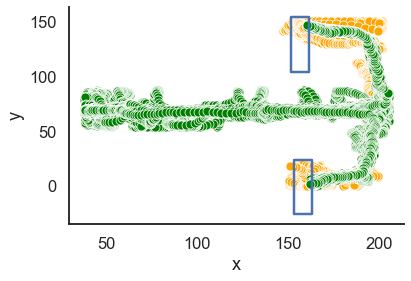

2020-11-10T11_26_11


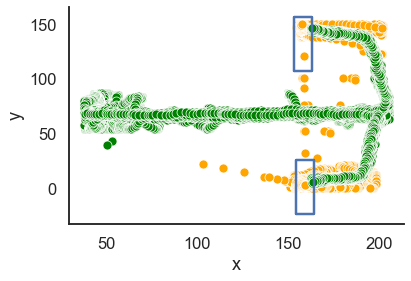

2020-11-11T09_36_04


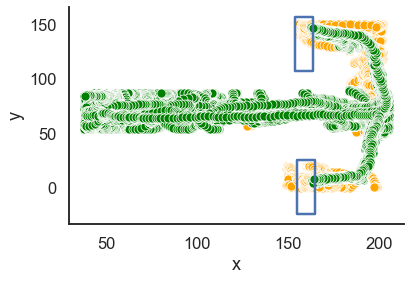

2020-11-12T13_00_04


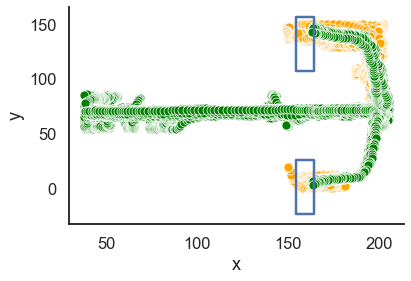

2020-11-16T09_48_33


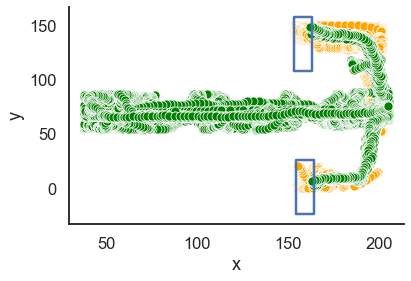

2020-11-18T09_56_35


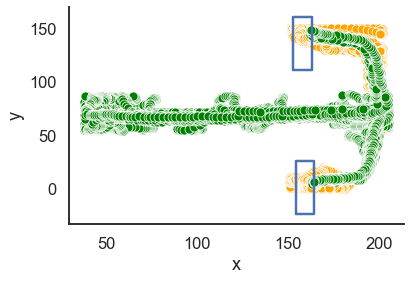

2020-11-19T09_00_26


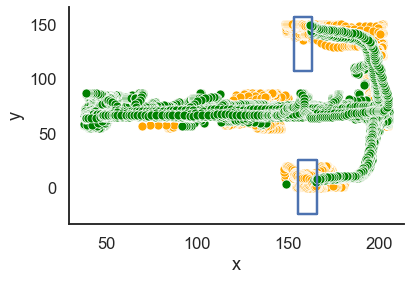

2020-11-19T09_33_22


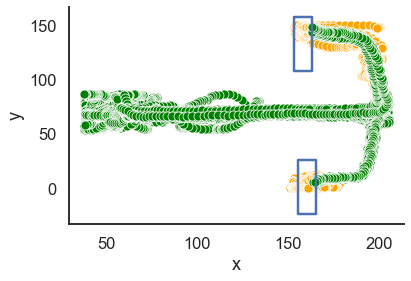

2020-11-20T08_15_22


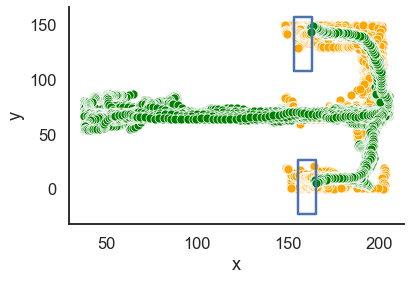

2020-11-24T09_56_24


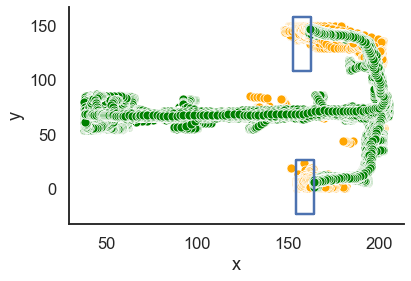

2020-11-26T11_15_50


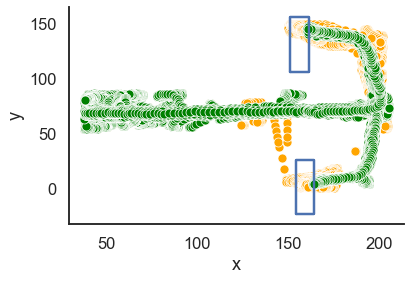

2020-11-27T12_31_07


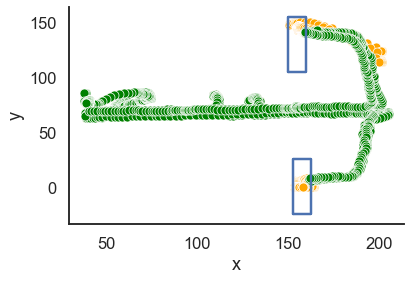

2020-11-27T12_42_22


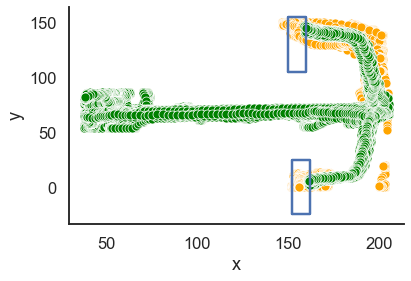

2020-11-30T11_19_35


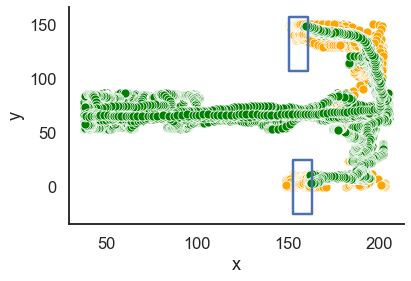

2020-12-01T15_23_42


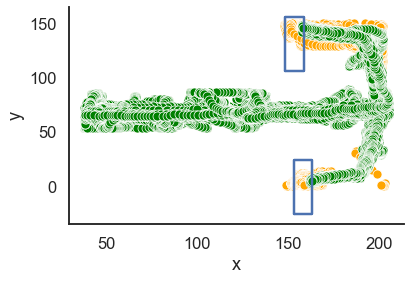

2020-12-02T11_41_19


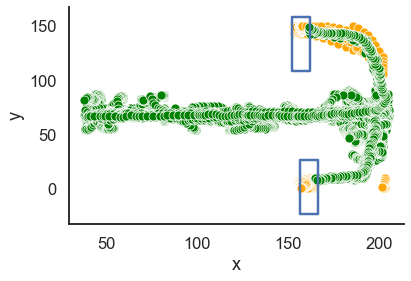

2020-12-02T12_06_57


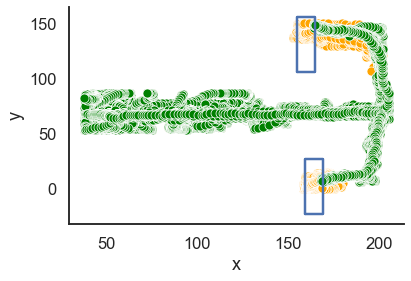

2020-12-03T12_54_02


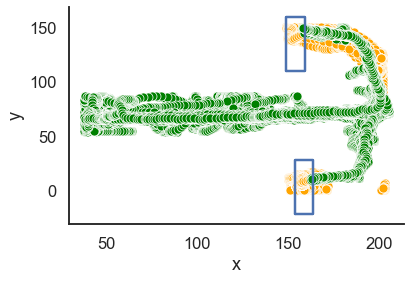

2020-12-04T08_29_50


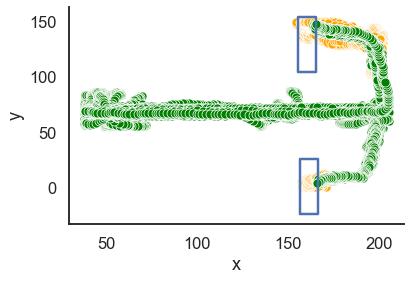

2020-12-07T11_44_05


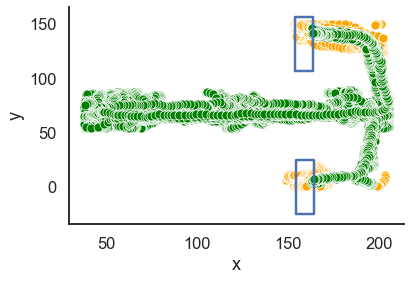

2020-11-25T09_53_37


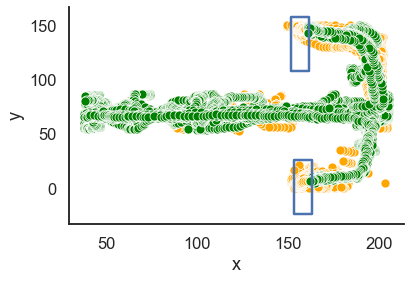

In [11]:
for session in sessions:
    print(session)
    session_df = df[df['session'] == session]
    session_df_pruned = df_pruned[df_pruned['session'] == session]
    
    rw1_x, rw1_y = find_session_roi_limits_to_plot(rw1_rois, session)
    rw2_x, rw2_y = find_session_roi_limits_to_plot(rw2_rois, session)
    
    sns.set(style='white', context='talk')
    a = sns.scatterplot(data=session_df, x='x', y='y', color='orange')
    a.plot(rw1_x, rw1_y, 'b')
    a.plot(rw2_x, rw2_y, 'b')

    sns.set(style='white', context='talk')
    a = sns.scatterplot(data=session_df_pruned, x='x', y='y', color='green')
    a.plot(rw1_x, rw1_y, 'b')
    a.plot(rw2_x, rw2_y, 'b')
    
    sns.despine()      
    plt.show()

## <font color=mediumseagreen> Save pruned data into a DataFrame

In [12]:
df_pruned = df_pruned.drop(['session', 'run_nr'], axis=1).reset_index().drop(['level_2'], axis=1)

In [13]:
#df_pruned

In [14]:
path = os.path.join(files_path, "Timestamped_position", "%s_timestamped_position_df_pruned.csv"%rat)
df_pruned.to_csv(path, header=df_pruned.columns)